In [1]:
import numpy as np
import math
import random
import warnings
from scipy.integrate import quad
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from scipy.fft import fft, ifft
import scipy.interpolate

import matplotlib as mpl
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.size'] = 7

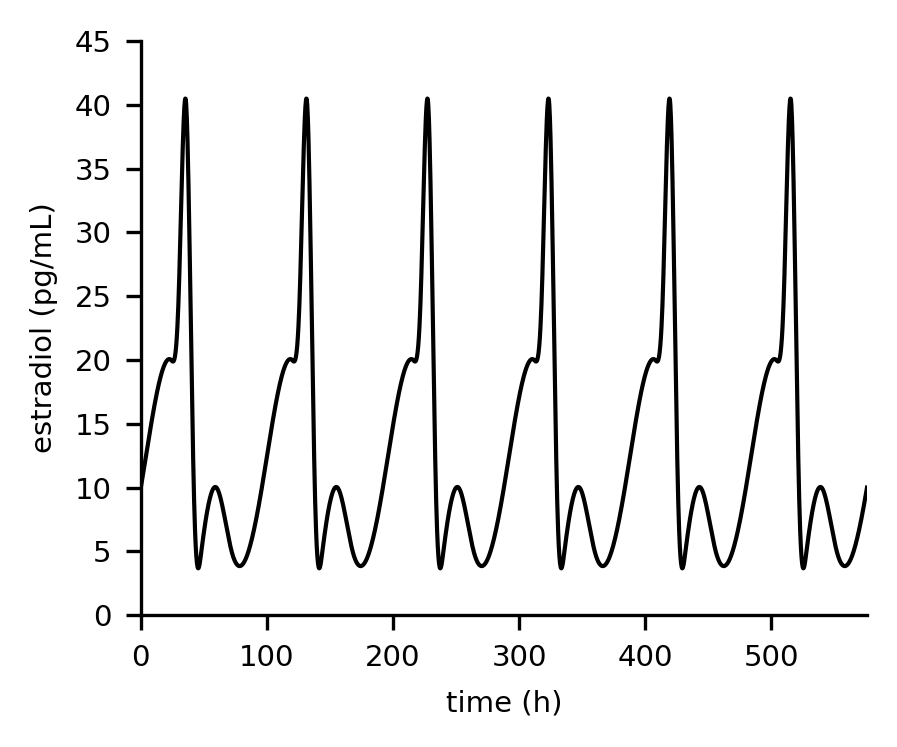

In [19]:
fig, ax = plt.subplots(figsize=(3,2.5), dpi=300)
times = np.arange(0,96*6+.25,0.25)
ax.plot(times, [estradiol_lvl(t) for t in times], color='k', lw=1)
ax.set_ylim([0,45])
ax.set_xlim([0, times[-1]])
ax.set_xlabel('time (h)')
ax.set_ylabel('estradiol (pg/mL)')
fig.tight_layout()
fig.savefig('estradiol_func.svg')

In [35]:
# Initial population sizes
init = [1,6,23,2]

# Time grid: from 0 to 20 in steps of 1
# 6 passes through full estrous cycle
times = np.arange(0, 96*6+.25, 0.25)

# Run simulation using gillespie_plus (nonhomogeneous Poisson process sampler)
res_list = []
for i in tqdm(range(8)):
    res_gillespie_plus = gillespie_plus(init, times, inten, state_change_matrix, nhpp)
    res_list.append(res_gillespie_plus)

  0%|          | 0/8 [00:00<?, ?it/s]/var/folders/nf/336h2vrj3gx4f2_bc7f8p98h0000gn/T/ipykernel_13548/3910395613.py:12: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(lambda x: sum(inten(tottime + x, pops)), 0, X, limit=200)
100%|██████████| 8/8 [1:08:55<00:00, 516.97s/it]


In [69]:
# Initial population sizes
init = [1,6,23,2]

# Time grid: from 0 to 20 in steps of 1
# 6 passes through full estrous cycle
times = np.arange(0, 96*6+.25, 0.25)

# Run simulation using gillespie_plus (nonhomogeneous Poisson process sampler)
res_list1 = []
for i in tqdm(range(8)):
    res_gillespie = gillespie_plus(init, times, inten, state_change_matrix, hpp)
    res_list1.append(res_gillespie)

100%|██████████| 8/8 [00:00<00:00, 10.21it/s]


In [70]:
res_list[0].shape

(2305, 5)

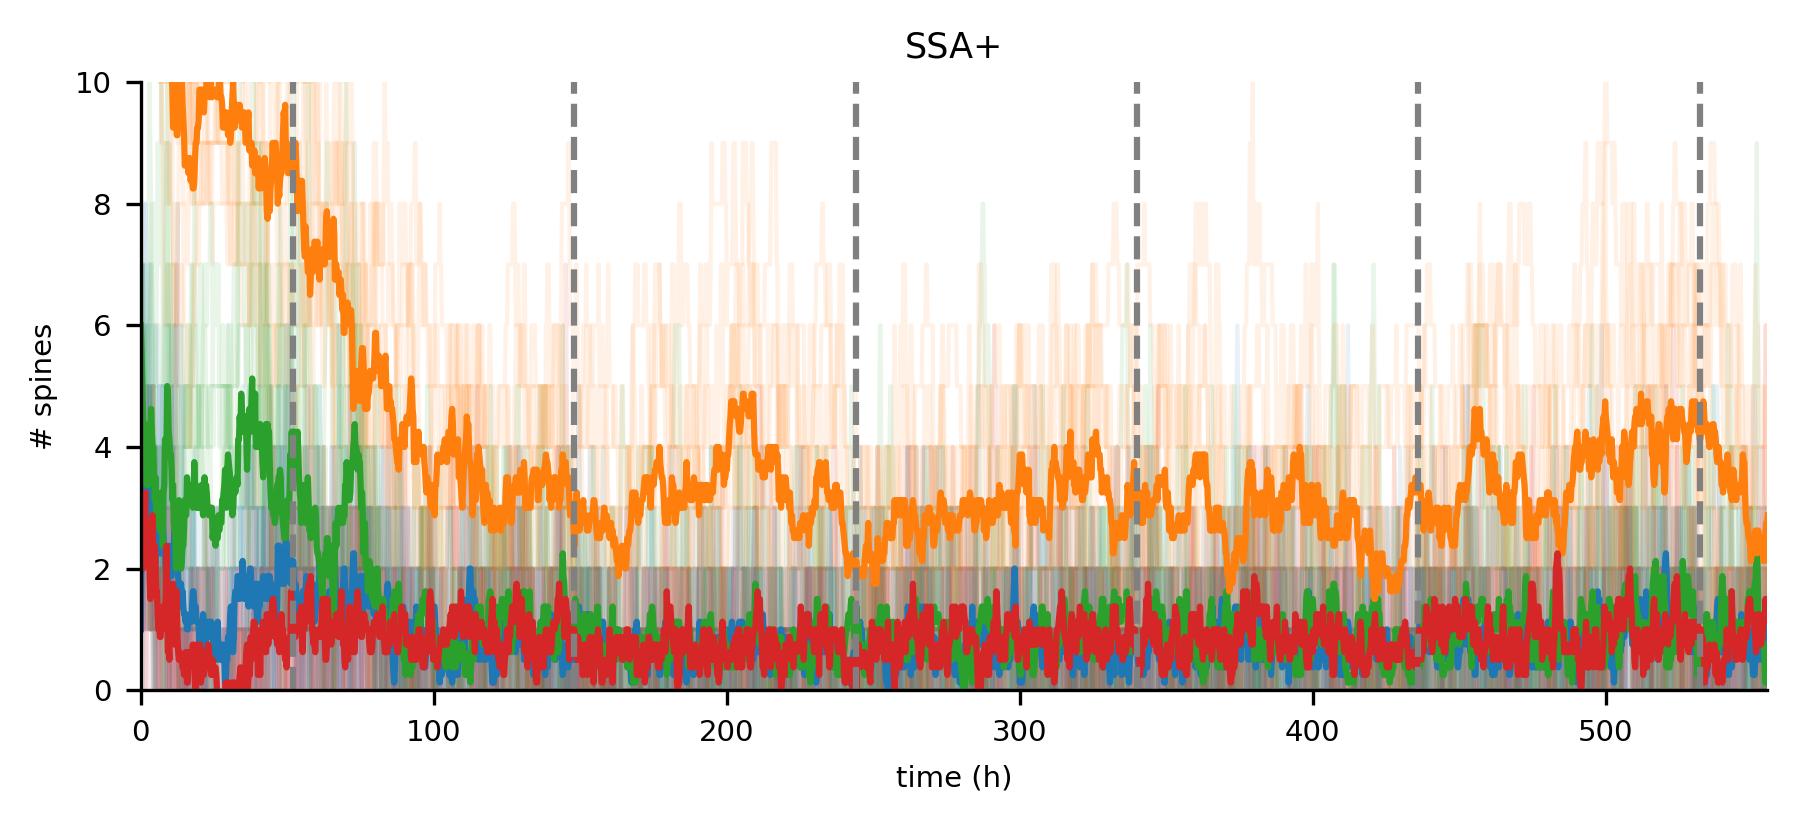

In [135]:
averages = np.zeros([
    np.size(res_list[0],0),
    4,
    8
])

fig, ax = plt.subplots(1, 1, dpi=300, figsize=(6,2.75))
for i in range(8):
    res_gillespie_plus = res_list[i]
    ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,1], label='F', lw=1, color='tab:blue', alpha=0.1)
    ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,2], label='H', lw=1, color='tab:green', alpha=0.1)
    ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,3], label='S', lw=1, color='tab:orange', alpha=0.1)
    ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,4], label='M', lw=1, color='tab:red', alpha=0.1)

    averages[:,0,i] = res_gillespie_plus[:,1]
    averages[:,1,i] = res_gillespie_plus[:,2]
    averages[:,2,i] = res_gillespie_plus[:,3]
    averages[:,3,i] = res_gillespie_plus[:,4]

ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,0,:], 1), color='tab:blue')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,1,:], 1), color='tab:green')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,2,:], 1), color='tab:orange')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,3,:], 1), color='tab:red')

ax.vlines(
    res_gillespie_plus[:,0][np.argwhere(res_gillespie_plus[:,0]%96==52).T],
    0,
    20,
    ls='--',
    color='gray'
)

ax.set_ylim([0,10])
ax.set_xlim([0,555])
ax.set_xlabel('time (h)')
ax.set_ylabel('# spines')
ax.set_title('SSA+')
fig.tight_layout()
fig.savefig('model_runs_x8.svg')

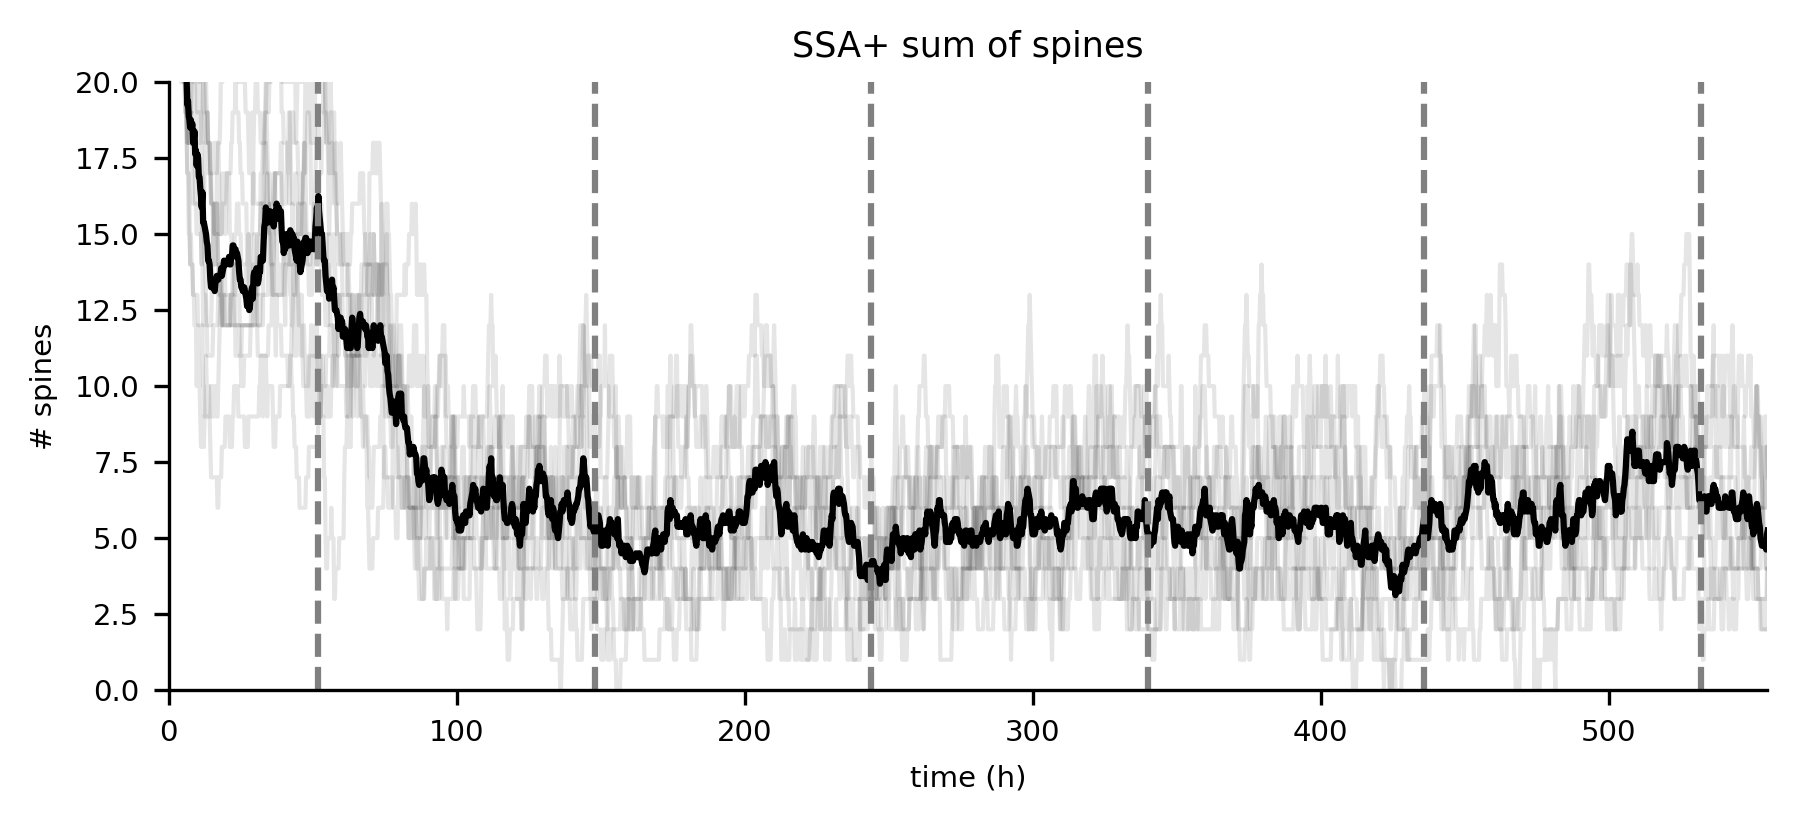

In [136]:
averages = np.zeros([
    np.size(res_list[0],0),
    8
])

fig, ax = plt.subplots(1, 1, dpi=300, figsize=(6,2.75))
for i in range(8):
    res_gillespie_plus = res_list[i]
    ax.plot(
        res_gillespie_plus[:,0],
        np.sum([
            res_gillespie_plus[:,1],
            res_gillespie_plus[:,2],
            res_gillespie_plus[:,3],
            res_gillespie_plus[:,4]
        ], axis=0),
        label='F', lw=1, color='k', alpha=0.1
    )

    averages[:,i] = np.sum([
        res_gillespie_plus[:,1],
        res_gillespie_plus[:,2],
        res_gillespie_plus[:,3],
        res_gillespie_plus[:,4]
    ], axis=0)

ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,:], 1), color='k')
# ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,1,:], 1), color='tab:green')
# ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,2,:], 1), color='tab:orange')
# ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,3,:], 1), color='tab:red')

ax.vlines(
    res_gillespie_plus[:,0][np.argwhere(res_gillespie_plus[:,0]%96==52).T],
    0,
    20,
    ls='--',
    color='gray'
)

ax.set_ylim([0,20])
ax.set_xlim([0,555])
ax.set_xlabel('time (h)')
ax.set_ylabel('# spines')
ax.set_title('SSA+ sum of spines')
fig.tight_layout()
fig.savefig('spine_sums_ssaplus.svg')

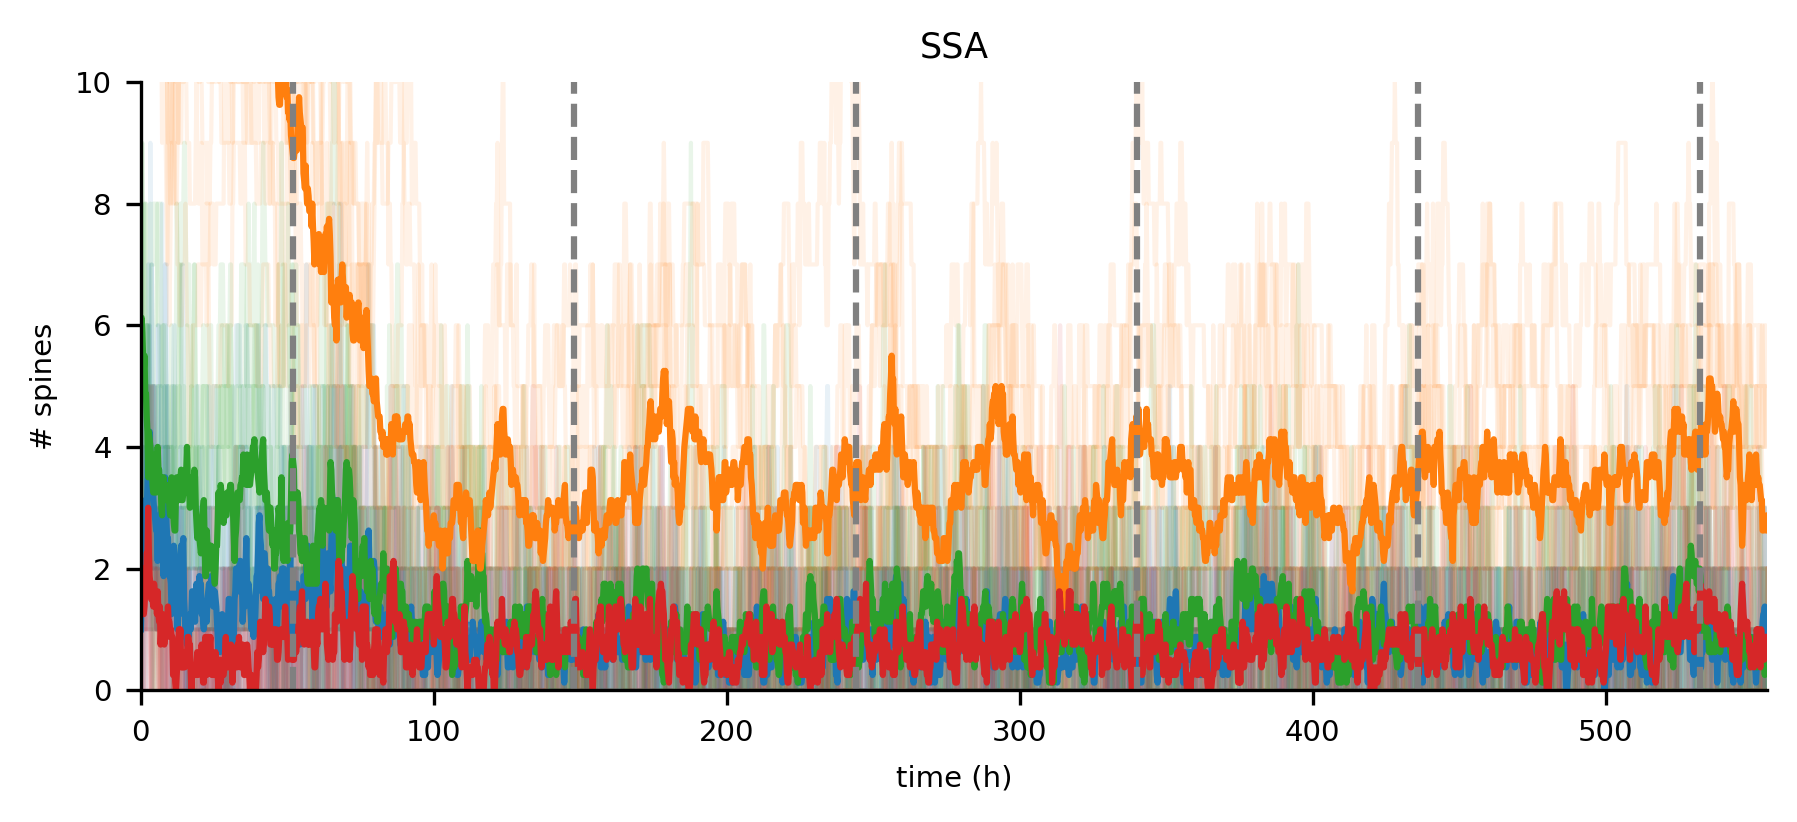

In [138]:
averages = np.zeros([
    np.size(res_list[0],0),
    4,
    8
])

fig, ax = plt.subplots(1, 1, dpi=300, figsize=(6,2.75))
for i in range(8):
    res_gillespie_plus = res_list1[i]
    ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,1], label='F', lw=1, color='tab:blue', alpha=0.1)
    ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,2], label='H', lw=1, color='tab:green', alpha=0.1)
    ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,3], label='S', lw=1, color='tab:orange', alpha=0.1)
    ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,4], label='M', lw=1, color='tab:red', alpha=0.1)

    averages[:,0,i] = res_gillespie_plus[:,1]
    averages[:,1,i] = res_gillespie_plus[:,2]
    averages[:,2,i] = res_gillespie_plus[:,3]
    averages[:,3,i] = res_gillespie_plus[:,4]

ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,0,:], 1), color='tab:blue')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,1,:], 1), color='tab:green')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,2,:], 1), color='tab:orange')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,3,:], 1), color='tab:red')

ax.vlines(
    res_gillespie_plus[:,0][np.argwhere(res_gillespie_plus[:,0]%96==52).T],
    0,
    20,
    ls='--',
    color='gray'
)

ax.set_ylim([0,10])
ax.set_xlim([0,555])
ax.set_xlabel('time (h)')
ax.set_ylabel('# spines')
ax.set_title('SSA')
fig.tight_layout()
fig.savefig('model_runs_homogenous_x8.svg')

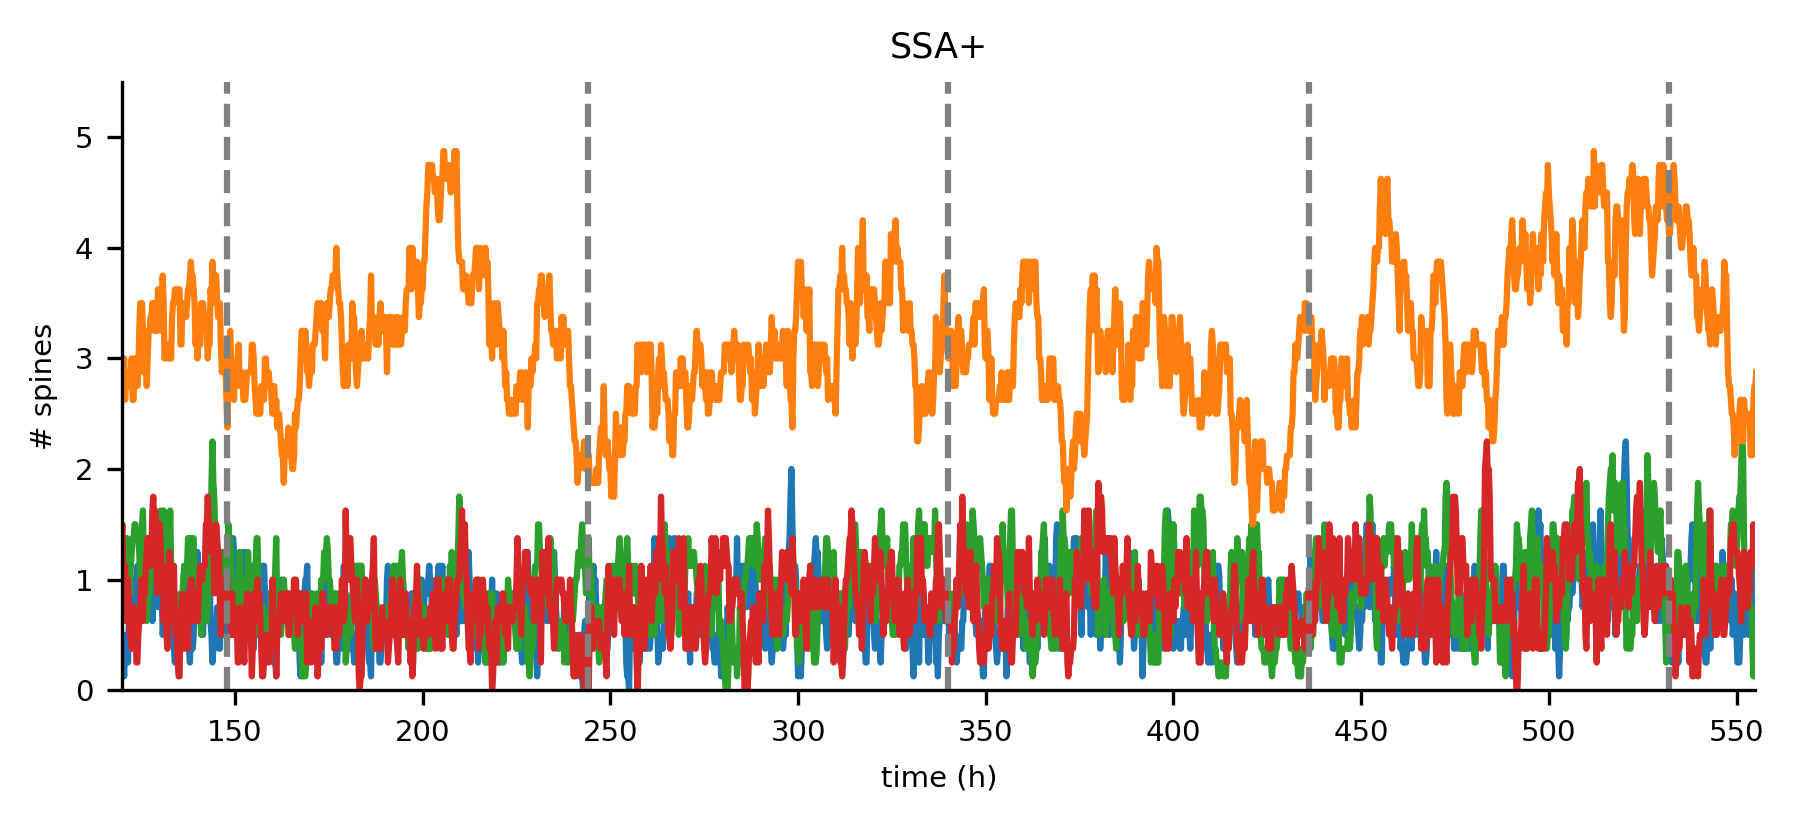

In [267]:
averages = np.zeros([
    np.size(res_list[0],0),
    4,
    8
])

fig, ax = plt.subplots(1, 1, dpi=300, figsize=(6,2.75))
for i in range(8):
    res_gillespie_plus = res_list[i]
    # ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,1], label='F', lw=1, color='tab:blue', alpha=0.2)
    # ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,2], label='H', lw=1, color='tab:green', alpha=0.2)
    # ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,3], label='S', lw=1, color='tab:orange', alpha=0.2)
    # ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,4], label='M', lw=1, color='tab:red', alpha=0.2)

    averages[:,0,i] = res_gillespie_plus[:,1]
    averages[:,1,i] = res_gillespie_plus[:,2]
    averages[:,2,i] = res_gillespie_plus[:,3]
    averages[:,3,i] = res_gillespie_plus[:,4]

ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,0,:], 1), color='tab:blue')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,1,:], 1), color='tab:green')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,2,:], 1), color='tab:orange')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,3,:], 1), color='tab:red')

ax.vlines(
    res_gillespie_plus[:,0][np.argwhere(res_gillespie_plus[:,0]%96==52).T],
    0,
    20,
    ls='--',
    color='gray'
)

ax.set_ylim([0,5.5])
ax.set_xlim([120,555])
ax.set_xlabel('time (h)')
ax.set_ylabel('# spines')
ax.set_title('SSA+')
fig.tight_layout()
fig.savefig('model_runs_x8_long.svg')
fig.savefig('model_runs_x8_long.png')

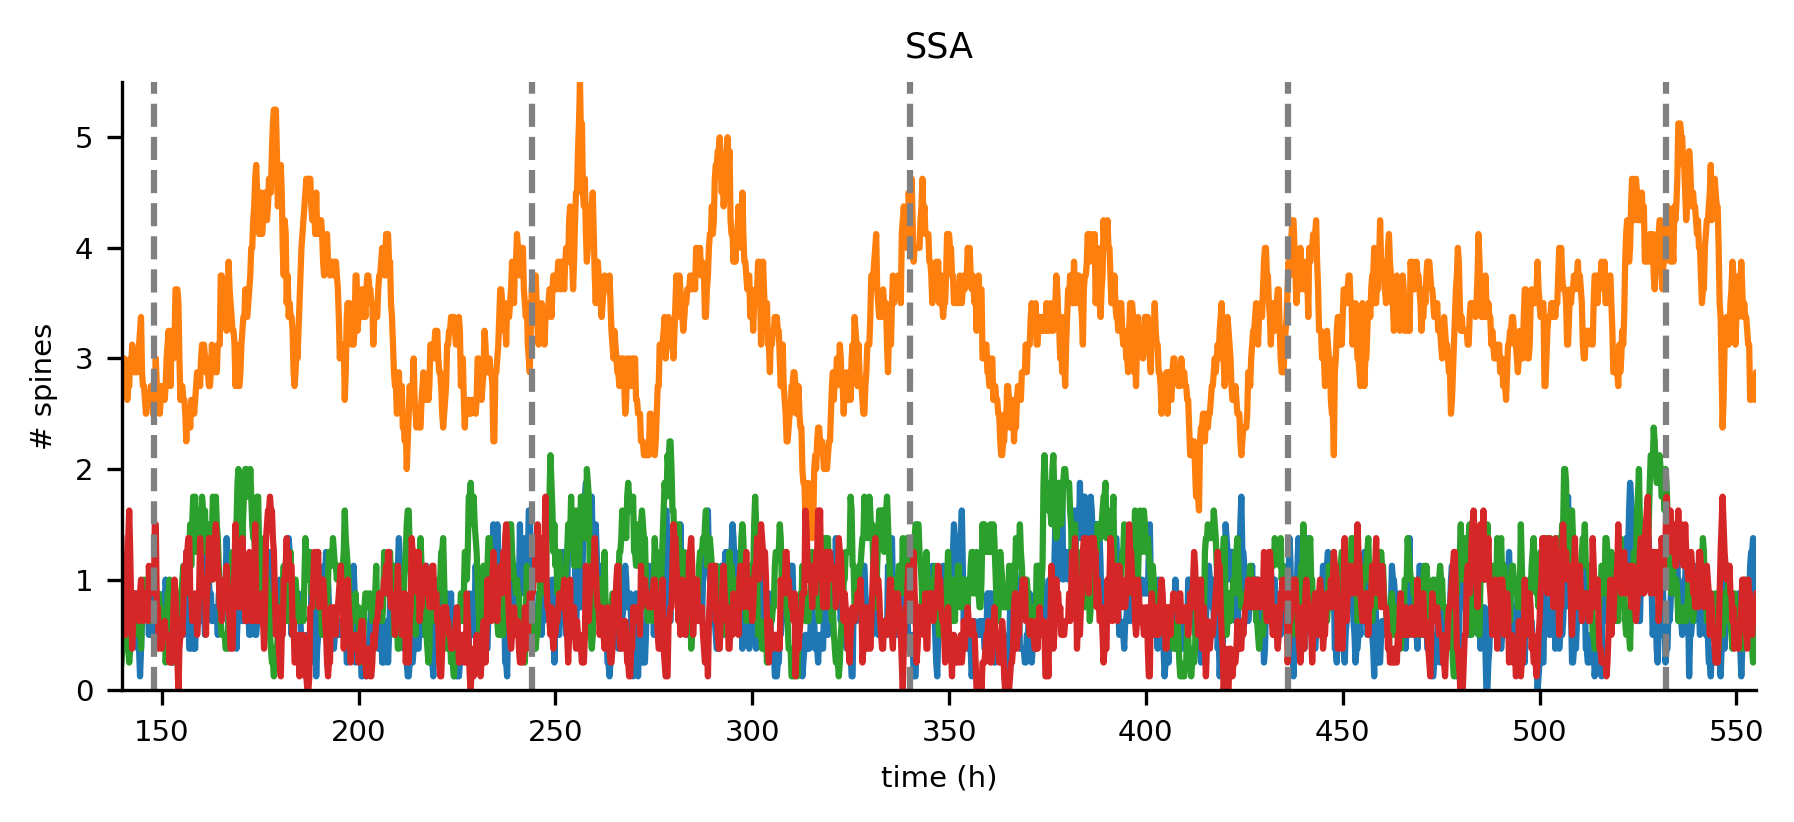

In [125]:
averages = np.zeros([
    np.size(res_list[0],0),
    4,
    8
])

fig, ax = plt.subplots(1, 1, dpi=300, figsize=(6,2.75))
for i in range(8):
    res_gillespie_plus = res_list1[i]
    # ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,1], label='F', lw=1, color='tab:blue', alpha=0.2)
    # ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,2], label='H', lw=1, color='tab:green', alpha=0.2)
    # ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,3], label='S', lw=1, color='tab:orange', alpha=0.2)
    # ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,4], label='M', lw=1, color='tab:red', alpha=0.2)

    averages[:,0,i] = res_gillespie_plus[:,1]
    averages[:,1,i] = res_gillespie_plus[:,2]
    averages[:,2,i] = res_gillespie_plus[:,3]
    averages[:,3,i] = res_gillespie_plus[:,4]

ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,0,:], 1), color='tab:blue')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,1,:], 1), color='tab:green')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,2,:], 1), color='tab:orange')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,3,:], 1), color='tab:red')

ax.vlines(
    res_gillespie_plus[:,0][np.argwhere(res_gillespie_plus[:,0]%96==52).T],
    0,
    20,
    ls='--',
    color='gray'
)

ax.set_ylim([0,5.5])
ax.set_xlim([140,555])
ax.set_xlabel('time (h)')
ax.set_ylabel('# spines')
ax.set_title('SSA')
fig.tight_layout()
fig.savefig('model_runs_homogenous_x8_long.svg')

In [ ]:
# calculate percent turnover
turnover_arr = np.zeros([8,np.size(res_list[0],0)-1]) * np.nan
for i in range(8):
    res_gillespie_plus = res_list1[i]
    for t in range(np.size(res_gillespie_plus, 0)-1):
        nt = np.abs(np.sum(res_gillespie_plus[t,1:]) - np.sum(res_gillespie_plus[t-1,1:]))
        tot_avg_spines = np.nanmean(res_gillespie_plus[200:,1:])
        turnover_arr[i,t] = nt / tot_avg_spines

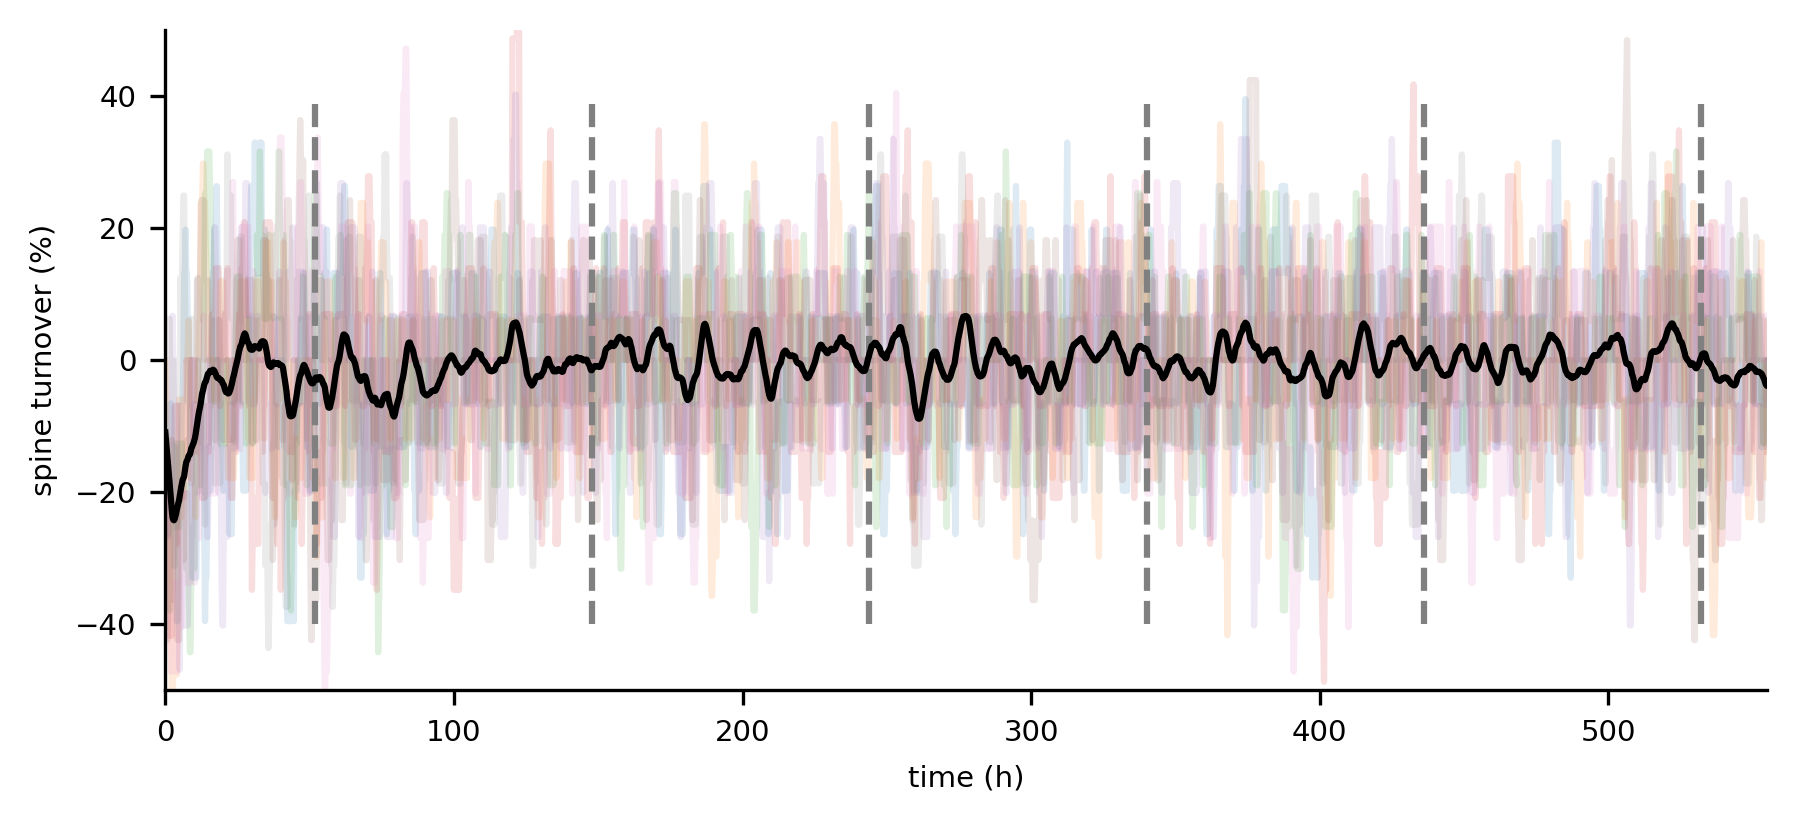

In [266]:
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(6,2.75))
turnover_boxcars = []
for i in range(8):
    ax.plot(res_gillespie_plus[:-2,0],
            boxcar_smooth(turnover_arr[i,1:]*100, 10), alpha=0.15)
    turnover_boxcars.append(boxcar_smooth(turnover_arr[i,1:]*100, 10))
ax.vlines(
    res_gillespie_plus[:,0][np.argwhere(res_gillespie_plus[:,0]%96==52).T],
    -40,
    40,
    ls='--',
    color='gray'
)

boxcar_mean_turnover = boxcar_smooth(np.mean(np.array(turnover_boxcars),0), 20)
ax.plot(res_gillespie_plus[:-2,0], boxcar_mean_turnover, color='k')
ax.set_ylim([-50,50])
ax.set_xlim([0,555])
ax.set_xlabel('time (h)')
ax.set_ylabel('spine turnover (%)')
fig.tight_layout()
fig.savefig('turnover_avg.svg')
fig.savefig('turnover_avg.png')

In [238]:
averages.shape

(2305, 4, 8)

In [239]:
turnover_arr =np.zeros([np.size(res_list[0],0)-1]) * np.nan
for t in range(np.size(res_gillespie_plus, 0)-1):
    nt = np.sum(np.mean(averages[t,1:],1),0) - np.sum(np.mean(averages[t-1,1:],1),0)
    tot_avg_spines = np.nanmean(res_gillespie_plus[200:,1:])
    turnover_arr[t] = nt / tot_avg_spines

In [245]:
turnover_arr.shape

(2304,)

(0.0, 555.0)

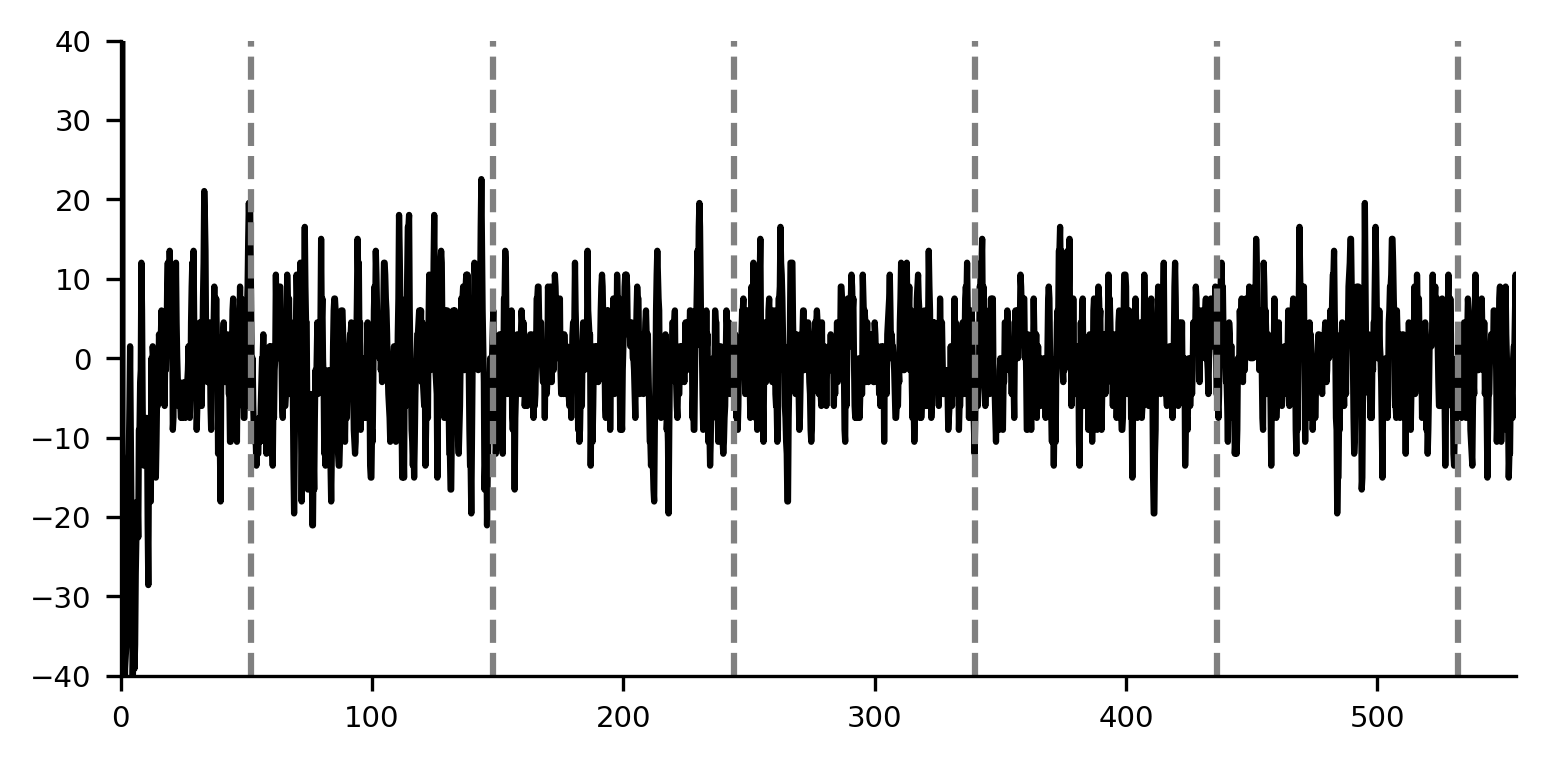

In [251]:
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(6,2.75))
ax.plot(
    res_gillespie_plus[:-1,0],
    boxcar_smooth(turnover_arr*100, 5), color='k')
ax.vlines(
    res_gillespie_plus[:,0][np.argwhere(res_gillespie_plus[:,0]%96==52).T],
    -40,
    40,
    ls='--',
    color='gray'
)

# boxcar_mean_turnover = boxcar_smooth(np.mean(turnover_arr[1:],0)*100, 20)
# ax.plot(res_gillespie_plus[:-2,0], boxcar_mean_turnover, color='k')
ax.set_ylim([-40,40])
ax.set_xlim([0,555])

In [126]:
def negative_log_likelihood(y_true, y_pred, sigma=1.0):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = len(y_true)
    nll = 0.5 * n * np.log(2 * np.pi * sigma**2) + np.sum((y_true - y_pred)**2) / (2 * sigma**2)
    return nll

In [ ]:
for i in range(8):
    res_gillespie_plus = res_list1[i]
    

array([False, False, False, ..., False, False, False])

In [ ]:
negative_log_likelihood(res_gillespie_plus)